In [1]:
df = (sqlContext.read.load("/guoda/data/idigbio-20170607T183747-1M.parquet")
    )

Calculate features

In [2]:
from pyspark.ml.linalg import Vectors, VectorUDT

#data = [(Vectors.dense([0.0, 0.0]),), (Vectors.dense([1.0, 1.0]),),
#       (Vectors.dense([9.0, 8.0]),), (Vectors.dense([8.0, 9.0]),)]
#print(spark.createDataFrame(data, ["features"]).head(10))

In [13]:
from pyspark.sql.functions import col, length, udf
import re

hex_chars = re.compile(r'[0-9a-fA-F]')
special_chars = re.compile(r'[\:\\\-_ ]')

def make_features(occurrenceid):
    return Vectors.dense(
        len(occurrenceid),
        len(re.findall(hex_chars, occurrenceid)),
        len(re.findall(special_chars, occurrenceid))
    )
    #return [float(len(occurrenceid)), 5.0]

make_features_udf = udf(make_features, VectorUDT())
    
# length(col("occurrenceid")
features = (df
            .select(col("occurrenceid"),
                make_features_udf(col("occurrenceid")).alias("features"))
            .persist()
            )

#features = df.rdd.map(lambda x: Vectors.dense(len(x["occurrenceid"])))

In [14]:
features.head(10)

[Row(occurrenceid='urn:uuid:856b9c56-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:83a78218-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:841d3b34-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:871242ee-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:863e9d4a-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:cb6a253a-003f-11e3-8e88-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:82cc4888-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:84be62b6-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:8517336e-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='

In [5]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=4, seed=1)
model = kmeans.fit(features)

In [6]:
centers = model.clusterCenters()
print(centers)

[array([ 51.26455571,  17.20590738,   1.19892206]), array([ 25.25105314,   9.94661374,   4.14829067]), array([ 43.88753181,  32.88285472,   5.75116927]), array([ 12.73601369,   8.24037639,   0.87339607])]


In [10]:
import pandas as pd
centers_df = pd.DataFrame(centers)
centers_df

,0,1,2
0,51.264556,17.205907,1.198922
1,25.251053,9.946614,4.148291
2,43.887532,32.882855,5.751169
3,12.736014,8.240376,0.873396


In [ ]:
# graph centers

In [ ]:
# what are the most important axes? pca

In [ ]:
# select those dimensions from graph centers and plot in 2 dimensions

That's cool, how do we know 4 is a good k?

In [62]:
# parallel arrays for the win
ks = []
models = []
centers = []
costs = []

for i in range(5, 21):
    kmeans = KMeans(k=i, seed=1)
    model = kmeans.fit(features)
    ks.append(i)
    models.append(model)
    centers.append(model.clusterCenters())
    costs.append(model.computeCost(features))



In [ ]:
# predict as a UDF to run on all data to find examples of things in the clusters

In [60]:
#print(models)
print(costs)

[478134.4818440371, 396891.6318830741, 212132.97895124086, 180022.46220084443, 146277.97113583615, 125794.83001545875, 124069.20752218677, 98241.41719851004, 96300.72588614676, 96300.72588614676, 64801.92774630434, 58450.79080184875, 56725.17823214374, 62447.164582512865, 66363.23671686856]


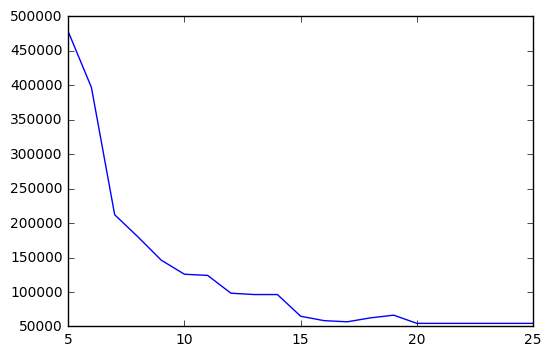

In [63]:
plt.plot(ks, costs)

In [103]:
final_k = 15

In [104]:
centers_df = pd.DataFrame(centers[ks.index(final_k)])
centers_df

,0,1,2
0,50.935868,16.926079,1.031349
1,24.399227,9.272392,4.005010
2,45.008303,33.008303,6.000000
3,36.000000,32.000000,4.000000
4,14.997839,8.996111,1.003889
5,17.000000,10.274566,1.000000
6,31.204960,16.142232,4.000000
7,30.180260,10.468423,4.999365
8,22.228219,8.916049,4.000000
9,58.841398,21.053763,5.451613


Need to count number of records for each cluster

In [105]:
final_model = models[ks.index(final_k)]

#.predict([51, 17, 1.1])

final_model.summary.predictions.head(10)

[Row(occurrenceid='urn:uuid:856b9c56-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrenceid='urn:uuid:83a78218-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrenceid='urn:uuid:841d3b34-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrenceid='urn:uuid:871242ee-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrenceid='urn:uuid:863e9d4a-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrenceid='urn:uuid:cb6a253a-003f-11e3-8e88-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrenceid='urn:uuid:82cc4888-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrenceid='urn:uuid:84be62b6-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrencei

In [109]:
sizes = (final_model.summary.predictions
         .groupBy(col("prediction"))
         .count()
         .orderBy(col("prediction"))
         .toPandas()
         )

max_size = 1000
sizes["scaled"] = (sizes["count"] / sizes["count"].max() ) * max_size

In [110]:
sizes.head(10)

,prediction,count,scaled
0,0,23701,655.974094
1,1,11377,314.881957
2,2,36131,1000.000000
3,3,5134,142.094047
4,4,2314,64.044726
5,5,1038,28.728792
6,6,1371,37.945255
7,7,3151,87.210429
8,8,5670,156.928953
9,9,372,10.295868


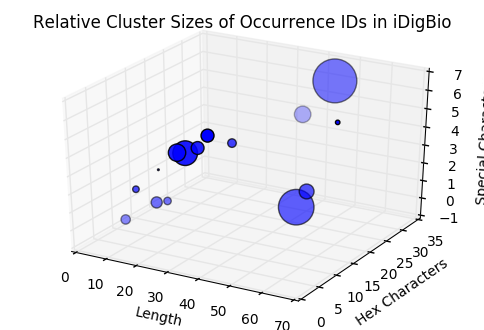

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=centers_df[0], ys=centers_df[1], zs=centers_df[2], s=sizes["scaled"])

plt.title("Relative Cluster Sizes of Occurrence IDs in iDigBio")
plt.xlabel("Length")
plt.ylabel("Hex Characters")
ax.set_zlabel("Special Characters")

lets take a look at a sampling of these clusters

In [122]:
for i in [0, 1, 2, 3]:
    print("Cluster {0}".format(i))
    print(final_model.summary.predictions
     .filter(col("prediction") == i)
     .select(col("prediction"), col("occurrenceid"))
     .limit(5)
     .toPandas()
     )

Cluster 0
   prediction                                       occurrenceid
0           0   http://coldb.mnhn.fr/catalognumber/mnhn/ey/ey241
1           0  http://coldb.mnhn.fr/catalognumber/mnhn/ey/ey6475
2           0  http://coldb.mnhn.fr/catalognumber/mnhn/ey/ey9659
3           0  http://coldb.mnhn.fr/catalognumber/mnhn/ey/ey9618
4           0  http://coldb.mnhn.fr/catalognumber/mnhn/ey/ey8863
Cluster 1
   prediction               occurrenceid
0           1  urn:catalog:trom:v:961366
1           1   urn:catalog:cas:ds:84042
2           1   urn:catalog:cas:ds:68327
3           1   urn:catalog:cas:ds:40983
4           1   urn:catalog:cas:ds:45273
Cluster 2
   prediction                                   occurrenceid
0           2  urn:uuid:856b9c56-d8e1-11e2-99a2-0026552be7ea
1           2  urn:uuid:83a78218-d8e1-11e2-99a2-0026552be7ea
2           2  urn:uuid:841d3b34-d8e1-11e2-99a2-0026552be7ea
3           2  urn:uuid:871242ee-d8e1-11e2-99a2-0026552be7ea
4           2  urn:uuid:863e9